# Homework 4 - Scalability

## CS109B / Stats 121 / AC209B / CSCI E109B

CS109b Staff

March 8, 2018

 ### Enter which version of the course you are enrolled in: 

 <span style="color:blue">
**ANSWER**
<br/>
I am enrolled in AC209b
 </span>

The purpose of this homework is get familiar with scalability and parallelization. 

There are three items to submit:

1. Via Canvas, this populated Jupyter notebook (.ipynb) file
2. Via Canvas, this populated notebook converted to PDF (for inline grading notes)
3. Anonymously share your performance results via this Google form [https://goo.gl/forms/EVrnxj2pzndZvNX22](https://goo.gl/forms/EVrnxj2pzndZvNX22)

## Part 1 - Theory

(a) 30% of your application can be parallelized. It takes 56 seconds to run on your single processor laptop, but only 42 seconds to run on your friend's beefy desktop. How many processors does your friend's machine have? Show your work.

<span style="color:blue">
**ANSWER**
<br/>
Suppose unit work takes t second on the single processor laptop, and t' second on the multi-processor laptop, then
$$0.7t + 0.3t = 56, \quad t = 56$$
$$0.7t + 0.3t' = 42, \quad 0.7 * 56 + 0.3t' = 42, \quad t' = \frac{28}{3}$$
Suppose there are N cores on the multi-processor laptop, then
$$3t = 3Nt'$$
$$N = \frac{t}{t'}= \frac{56}{\frac{28}{3}} = 6$$
<br/>
<br/>
The same result can be achived by Amdahl's law:
$$S_{latency} = \frac{1}{1-p+\frac{p}{N}}$$
Plug in the values for each term, we have
$$\frac{56}{42} = \frac{1}{1-0.3+\frac{0.3}{N}}$$
Therefore, 
$$N = \frac{0.3}{\frac{42}{56} - 0.7} = 6$$
</span>

(b) The NVIDIA Telsa K80 in your JupyterHub instances has 4992 cores ([source](http://www.nvidia.com/object/tesla-k80.html)). You have to perform a very large matrix multiplication. Explain what factors would prevent the operation from occurring about 5000 times faster than running the same operation on a single CPU machine. What are the bottlenecks? 

<span style="color:blue">
**ANSWER**
<br/>
Factors preventing the operation from complete parallization: 
<br/>
1) Amdahl's law: $$S_{latency} = \frac{1}{1-p+\frac{p}{N}}$$ 
For $S_{latency} = N$, we need $p = 1$, which is 100% parallelism in the code. Therefore, little parallelism in the code (E.g. large proportion of the code involves explicit loops which force sequential computation by iteration) is one of the major factors that prevents the operation to be 5000 times faster.
<br/>
<br/>
2) Networking and communication among cores can have large overhead.
<br/>
<br/>
3) Synchronization of parallel tasks taking place at different cores takes waiting time.
<br/>
<br/>
4) There could be other simultaneously running tasks that also occupy some of the computing resources.
<br/>
<br/>
All these factors prevent complete parallelization and makes the bottlenecks for GPU speed up.
</span>

## Part 2 - Coding

In this part, we are going to experiment with having code execute in parallel on multiple cores. Let's first determine how many cores a given machine has.

You can run this code on your local machine or on your JupterHub instance. Either is fine.

### 2.1 Setup

In [1]:
from multiprocessing import Process
from multiprocessing import cpu_count
import numpy as np
import time
import random

In [2]:
cpu_count()

4

Every major operating system (MacOS, Windows, Linux) have a means of monitoring CPU utilization across cores.

For MacOS, open `Activity Monitor`, and select CPU usage

For MS-Windows, open `Task Manager`, and look at the performance tab

For Linux, there is the command line `top` command, or for Ubuntu, use `System Monitor`

Verify that the number of cores shown in the appropriate tool corresponds to the number of processors shown above. Leave the CPU monitor window open as it will be used in the subsequent exercises.

**Optional advanced**: your machine may have only half the physical cores listed above. For example, on MacOS, if you go to `Apple` / `About This Mac` / `System Report` only four physical cores could be listed instead of the reported eight. This is due to [hyperthreading](https://en.wikipedia.org/wiki/Hyper-threading). See also [Optimizing Cores](https://macperformanceguide.com/Optimizing-Cores.html)

How many processors are reported above? Does it match what your OS is saying? 

<span style="color:blue">
**ANSWER**
<br/>
The above reported `cpu_count()` is 4.
<br/>
But my MAC system report says a total of 2 cores.
</span>

### 2.2 Sequential Operations

Here we are going to write some Python that executes in parallel across multiple cores. Specifically, we are going to implement prime factorization in regular Python that operates in parallel across multiple cores.

First, let's look at the sequential version:

In [3]:
from sympy import sieve
MAX_NUM = 1000000
PRIMES = list(sieve.primerange(2,MAX_NUM // 2 + 1))


# the number of composite numbers to factor
N = 1000

In [4]:
def calculatePrimeFactors(n):
    primfac = []
    d = 2
    while d*d <= n:
        while (n % d) == 0:
            primfac.append(d)  # supposing you want multiple factors repeated
            n //= d
        d += 1 
    if n > 1:
        primfac.append(n)
    return primfac

In [5]:
print("Starting number crunching")
t0 = time.time()
for i in range(N):
    rand = random.choice(PRIMES) * random.choice(PRIMES) 
    factors = calculatePrimeFactors(rand)
    if (i % (N//10) == 0):
        print(factors)
t1 = time.time()
totalTime = t1 - t0
print("Execution Time: {}".format(totalTime))

Starting number crunching
[87803, 417119]
[52673, 449693]
[160253, 312397]
[40427, 486133]
[226903, 237379]
[121189, 496477]
[154247, 220511]
[159779, 496631]
[92893, 115057]
[100271, 469253]
Execution Time: 32.15517497062683



Now, change the line `N = 100` above so the sequential version takes at least a few seconds to run. Increase by orders of magnitude. You may need a value of `N = 1000` on a recent MacBook for example.

What value of N did you choose and how long did it take to run?

<span style="color:blue">
**ANSWER**
<br/>
N = 1000, Execution Time: 32.15517497062683
</span>

### 2.3 Parallel Operations

Let's run in parallel across multiple CPUs.

In [6]:
# Now let's run it concurrently
def executeProc(nProc):
    # Each process is performing a fraction of the load
    # so it has less numbers to factor
    myN = N // nProc
    for i in range(myN):
        rand = random.choice(PRIMES) * random.choice(PRIMES) 
        factors = calculatePrimeFactors(rand)
        if (i % (myN // 10 * nProc) == 0):
            print(factors)        

In [7]:
total_times = []
nProcs = list(range(1, 11))
for nProc in nProcs:
    t0 = time.time()
    procs = []
    # Here we create our processes and kick them off
    for i in range(nProc):
        proc = Process(target=executeProc, args=(nProc,))
        procs.append(proc)
        proc.start()
    # We use the .join() method in order to wait for
    # execution to finish for all of our processes
    for proc in procs:
        proc.join()
    t1 = time.time()
    totalTime = t1 - t0
    total_times.append(totalTime)
    # we print out the total execution time for our 10 procs.
    print("nProc = {}, Execution Time: {}".format(nProc, totalTime))

[48859, 162229]
[336689, 492377]
[388963, 470087]
[20023, 62761]
[298819, 393361]
[29327, 127807]
[230149, 362741]
[37337, 136777]
[174569, 337223]
[347051, 425309]
nProc = 1, Execution Time: 33.17695498466492
[120823, 142619]
[390307, 404977]
[192193, 254071]
[252713, 461957]
[85549, 179909]
[76907, 188857]
[127579, 304831]
[146681, 392827]
[227651, 270443]
[28631, 407321]
nProc = 2, Execution Time: 15.587459802627563
[10627, 179801]
[5039, 192631]
[216379, 413759]
[369829, 403717]
[93251, 139747]
[78347, 258743]
[138799, 311867]
[362177, 403679]
[159979, 163327]
[220889, 423251]
[73039, 182857]
[268519, 432659]
nProc = 3, Execution Time: 17.332058906555176
[73039, 305483]
[178069, 212987]
[289349, 451523]
[330053, 379903]
[56003, 349121]
[152417, 188459]
[122701, 148457]
[22381, 468887]
[158129, 406207]
[306133, 356533]
[255019, 390791]
[442397, 478171]
nProc = 4, Execution Time: 19.120845079421997
[23677, 104233]
[29581, 382847]
[91183, 140381]
[330227, 467543]
[316703, 448067]
[635

Now, change the line `nProc = 2` above so we use more parallel processors. Increase by 1 or 2 at a time. You may need a value of `nProc = 10` on a recent MacBook for example. Modify the code above to keep track of execution time by number of processes.

What value of nProc produced the fastest time?  

In [8]:
min_idx = total_times.index(min(total_times))
min_nProc = nProcs[min_idx]
print('The value of nProc producint the fastest time: {}'.format(min_nProc))
print('Fastest Execution Time: {}'.format(total_times[min_idx]))

The value of nProc producint the fastest time: 2
Fastest Execution Time: 15.587459802627563


<span style="color:blue">
**ANSWER**
<br/>
**nProc = 2** produces the fastest execution time. Execution time remains similar for nProc $\geq$ 2.
<br/>
Fastest Execution Time = 15.587459802627563
<br/>
</span>

### 2.4 - Plotting and Interpretation

(a) Plot the execution time vs number of processes from 1 to nProc + 4 (ie. if nProc == 10 was optimal, plot from 1 to 14 processes). 

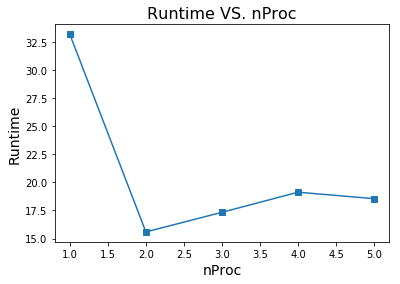

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(nProcs[:min_idx+4], total_times[:min_idx+4], 's-')
plt.title('Runtime VS. nProc', fontsize=16)
plt.xlabel('nProc', fontsize=14)
plt.ylabel('Runtime', fontsize=14)
plt.show()

(b) According to your OS's CPU monitor, were all cores in use?

<span style="color:blue">
**ANSWER**
<br/>
According to the OS's CPU monitor, 2 cores were in use when **nProc = 1** and all 4 cores were in use when **nProc $\geq$ 2**.
</span>

(c) Why was this optimal based on the number of cores that you have? Why does a higher number of processes not speed things up? How many physical cores do you suspect your machine has vs the number reported by `cpu_count()` in 2.1?

<span style="color:blue">
**ANSWER**
<br/>
The minimum runtime takes place when **nProc = 2** and a higher number of processes does not speed things up. This could be seen from the CPU monitor which shows the OS uses 2 cores when nProc = 1 and all 4 cores when nProc $\geq$ 2. However the OS sees more cores than the actual number of physical cores due to [hyperthreading](https://en.wikipedia.org/wiki/Hyper-threading), which increases the number of independent instructions in the pipeline by allowing concurrent processes scheduling per core. Therefore, the OS uses 2 virtual cores which is actually 1 physical core when nProc = 1 and 4 virtual cores which is actually 2 physical cores when nProc $\geq$ 2. I think my MAC has **2 physical cores** instead of `cpu_count() = 4`.
</span>

### Part 3 - AC209 Problem

Implement prime factorization using `numpy`.

Hint: the book Numpy Cookbook available through Hollis may help you.

Use your function and the same number of `N` sequential cases as above. Time the result.

* How long did numpy take vs the sequential and parallel versions?
* Was your implementation faster than numpy?
* Was numpy using multiple cores or not?

**For all students:**
Don't forget to post your results to  [https://goo.gl/forms/EVrnxj2pzndZvNX22](https://goo.gl/forms/EVrnxj2pzndZvNX22)

In [10]:
import numpy as np

LIM = 10**6

def factor(n, prime_factors):
    '''
    Function of prime number factorization that get rid of 2 for even numbers 
    and calls the prime factorization function for odd numbers from the numpy cookbook 
    '''
    while n % 2 == 0:
        n //= 2
        prime_factors.append(2)
    if n > 1:
        factor_odd(n, prime_factors)
    return prime_factors

def factor_odd(n, prime_factors): 
    '''
    Function of prime factorization for odd numbers from the numpy cookbook 
    '''
    #1. Create array of trial values
    a = np.ceil(np.sqrt(n))
    lim = min(n, LIM)
    a = np.arange(a, a + lim)
    b2 = a**2 - n
    
    #2. Check whether b is a square
    fractions = np.modf(np.sqrt(b2))[0]
    
    #3. Find 0 fractions
    indices = np.where(fractions == 0)
    
    #4. Find the first occurrence of a 0 fraction
    a = int(a[indices][0])
    b = int(np.sqrt(a**2 - n))
    c = a + b
    d = a - b
    if c == 1 or d == 1: 
        if c == 1:
            prime_factors.append(d)
        else:
            prime_factors.append(c)
        return
    
    factor_odd(c, prime_factors)
    factor_odd(d, prime_factors)

In [11]:
prime_factors = []
n = 26
prime_factors = factor(n, prime_factors)
prime_factors

[2, 13]

In [12]:
calculatePrimeFactors(n)

[2, 13]

In [13]:
# Time the Numpy Factorization
N = 1000

print("Starting numpy prime factorizing")
t0 = time.time()
for i in range(N):
    factors = []
    rand = random.choice(PRIMES) * random.choice(PRIMES) 
    factor_odd(rand, factors)
    if (i % (N//10) == 0):
        print(factors)
t1 = time.time()
totalTime = t1 - t0
print("Execution Time: {}".format(totalTime))

Starting numpy prime factorizing
[130643, 66103]
[393581, 67631]
[332201, 283637]
[422041, 57829]
[351731, 42293]
[467261, 240349]
[476639, 25147]
[458533, 225143]
[398819, 211661]
[419999, 29131]
Execution Time: 31.630956172943115


<span style="color:blue">
**ANSWER**
<br/>
The numpy prime factorization took 31.630956172943115 seconds. The sequential version from 2.2 took 32.15517497062683 seconds. The parallel versions from 2.3 took 15 $\sim$ 18 seconds. 
<br/>
The parallel version was obviously faster than the numpy implementation, but the sequential version took similar time.
<br/>
As seen from the CPU monitor, the numpy implementation was using 2 vitual cores (4 vitual cores available in total).
</span>